## Download data yang diperlukan

In [ ]:
!wget \
  --no-check-certificate \
  https://raw.githubusercontent.com/julardos/StudentsAttendance/master/haarcascade_frontalface_default.xml \
  -O haarcascade_frontalface_default.xml
!wget  \
  --no-check-certificate \
  https://raw.githubusercontent.com/julardos/StudentsAttendance/master/res10_300x300_ssd_iter_140000.caffemodel \
!wget  \
  --no-check-certificate \
  https://raw.githubusercontent.com/julardos/StudentsAttendance/master/datasets.zip \
!wget  \
  --no-check-certificate \
  https://raw.githubusercontent.com/julardos/StudentsAttendance/master/deploy.prototxt.txt \

--2020-06-10 13:04:44--  https://raw.githubusercontent.com/julardos/StudentsAttendance/master/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2020-06-10 13:04:45 (23.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2020-06-10 13:04:47--  https://raw.githubusercontent.com/julardos/StudentsAttendance/master/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443..

## Mengolah Datasets

In [ ]:
import zipfile,shutil
local_zip = '/content/datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/datasets/'

In [ ]:
import numpy as np
import os
import cv2

images = []
labels = []
labels_dic = {}
people = [person for person in os.listdir(base_dir)]
for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir(base_dir + person):
                images.append(cv2.imread(base_dir + person + '/' + image, 0))
                labels.append(person)
                
labels = np.array(labels)

Jalankan kode dibawah ini sekali saja jika berhasil, karena saya belum menyiapkan exception untuk menghapus file lama jika terbuat

In [ ]:
class FaceDetector(object):
    def __init__(self, deploy_path, caffe_path):
        self.net = cv2.dnn.readNetFromCaffe(deploy_path, caffe_path)
  
    def detect(self, image, biggest_only=True):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        (h, w) = image.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(
            image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0)
            )
        self.net.setInput(blob)
        detections = self.net.forward()
        faces_coord = []
        for i in range(0, detections.shape[2]):
          confidence = detections[0, 0, i, 2]
          if confidence > 0.5:
            faces_coord.append((detections[0, 0, i, 3:7] * np.array([w, h, w, h])).astype("int"))
        faces_coord = np.array(faces_coord)
        return faces_coord

def cut_faces(image, faces_coord):
    faces = []
    
    for (startX, startY, endX, endY) in faces_coord:
      slicer = image[startY:endY, startX:endX]
      if (len(slicer)) :
        faces.append(slicer)
    
    return faces

def resize(images, size=(224, 224)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm



def normalize_faces(image, faces_coord):

    faces = cut_faces(image, faces_coord)
    #faces = resize(faces)
    
    return faces

count = 0
directory = "/tmp/new_datasets/"

try:
    os.makedirs(directory) 
except FileExistsError:
    print("Directory " , directory ,  " already exists") 

os.chdir(directory)
for label in range(len(labels_dic)):
    path = os.path.join(directory, labels_dic[label])
    try:
      os.mkdir(path)
    except FileExistsError:
      print("Directory " , path ,  " already exists") 

for (i, image) in enumerate(images):
    detector = FaceDetector('/content/deploy.prototxt.txt', '/content/res10_300x300_ssd_iter_140000.caffemodel')
    faces_coord = detector.detect(image, True)
    faces = normalize_faces(image ,faces_coord)
    os.chdir(directory + "/" + labels[i])
    for i, face in enumerate(faces):
            cv2.imwrite('%s.jpeg' % (count), faces[i])
            count += 1  

Directory  /tmp/new_datasets/  already exists
Directory  /tmp/new_datasets/2103181007  already exists
Directory  /tmp/new_datasets/2103181010  already exists
Directory  /tmp/new_datasets/2103181005  already exists
Directory  /tmp/new_datasets/2103181003  already exists
Directory  /tmp/new_datasets/2103181013  already exists
Directory  /tmp/new_datasets/2103181030  already exists
Directory  /tmp/new_datasets/2103181006  already exists
Directory  /tmp/new_datasets/2103181026  already exists
Directory  /tmp/new_datasets/2103181018  already exists
Directory  /tmp/new_datasets/2103181014  already exists
Directory  /tmp/new_datasets/2103181008  already exists
Directory  /tmp/new_datasets/2103181023  already exists
Directory  /tmp/new_datasets/2103181019  already exists
Directory  /tmp/new_datasets/2103181015  already exists
Directory  /tmp/new_datasets/2103181011  already exists
Directory  /tmp/new_datasets/2103181020  already exists
Directory  /tmp/new_datasets/2103181004  already exists
Di



## Kode dibawah ini merupakan kode untuk mengtrain dataset yang sudah diolah oleh kode sebelumnya

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    validation_split = 0.2)

In [ ]:
base_dir = "/tmp/new_datasets"

train_generator = train_datagen.flow_from_directory(
        base_dir,  
        target_size=(150, 150),  
        batch_size=4,
        class_mode='categorical',
        subset="training")

validation_generator = train_datagen.flow_from_directory(
        base_dir,  
        target_size=(150, 150),  
        batch_size=4,
        class_mode='categorical',
        subset="validation")

Found 214 images belonging to 27 classes.
Found 47 images belonging to 27 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(27, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=30,
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=4,
      verbose=2)


Epoch 1/20
30/30 - 4s - loss: 3.3192 - accuracy: 0.0254 - val_loss: 3.2926 - val_accuracy: 0.0000e+00
Epoch 2/20
30/30 - 4s - loss: 3.2858 - accuracy: 0.0508 - val_loss: 3.2927 - val_accuracy: 0.0000e+00
Epoch 3/20
30/30 - 4s - loss: 3.2894 - accuracy: 0.0254 - val_loss: 3.2502 - val_accuracy: 0.0625
Epoch 4/20
30/30 - 4s - loss: 3.2474 - accuracy: 0.0508 - val_loss: 3.2828 - val_accuracy: 0.0000e+00
Epoch 5/20
30/30 - 4s - loss: 3.1926 - accuracy: 0.0593 - val_loss: 3.1995 - val_accuracy: 0.0625
Epoch 6/20
30/30 - 4s - loss: 3.0217 - accuracy: 0.1186 - val_loss: 3.1180 - val_accuracy: 0.2500
Epoch 7/20
30/30 - 4s - loss: 3.0699 - accuracy: 0.1417 - val_loss: 2.9286 - val_accuracy: 0.0625
Epoch 8/20
30/30 - 4s - loss: 2.8558 - accuracy: 0.1583 - val_loss: 2.6775 - val_accuracy: 0.2500
Epoch 9/20
30/30 - 4s - loss: 2.9672 - accuracy: 0.1610 - val_loss: 2.6535 - val_accuracy: 0.1250
Epoch 10/20
30/30 - 4s - loss: 2.5784 - accuracy: 0.2034 - val_loss: 3.0974 - val_accuracy: 0.1250
Epoch 1

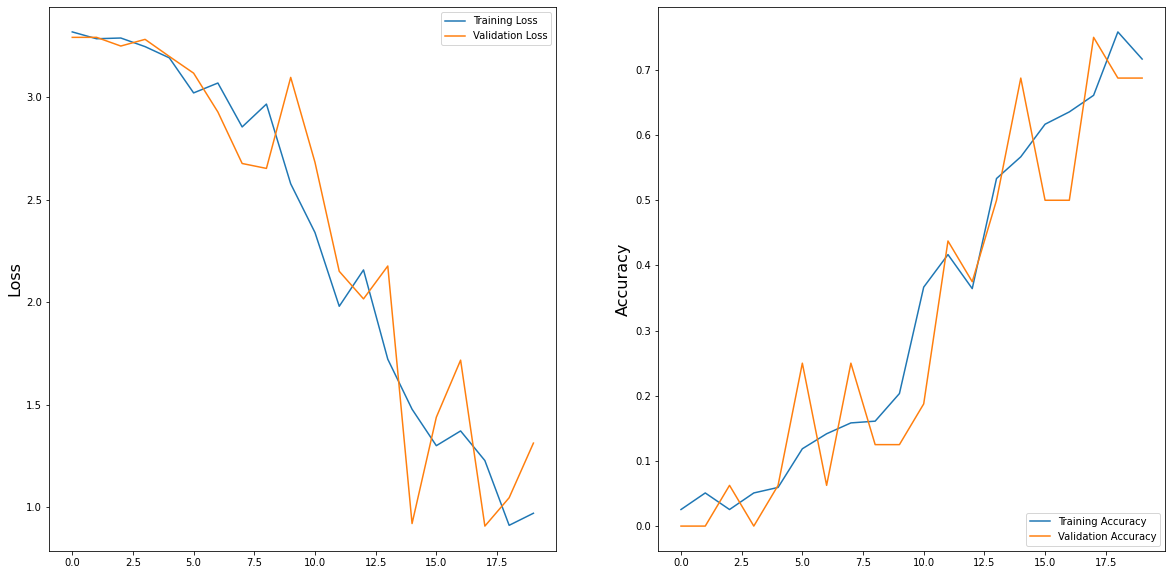

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Saving 28.jpeg to 28.jpeg
2103181003


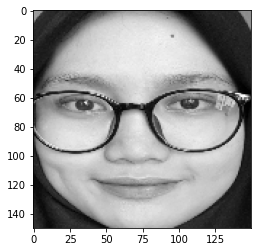

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=4)
  result = np.argmax(classes)
  print(labels_dic[result])